## K-Means Cluster Analysis of Fidelity Fund Returns 
### University of Virginia
### DS 7200: Distributed Computing
### Last Updated: August 20, 2023

## Instructions

In this assignment, you will conduct a k-means cluster analysis on a set of Fidelity mutual funds.  
This helps to group similar funds based on their performance (as opposed to their description, which is typical).  
The outline below will walk you through the required steps.  

This assignment is worth a total of **10 POINTS.**

## Data Details 

The file *fido_returns_funds_on_rows.csv* is the processed data for k-means. Additional details about this file: 
- Each row represents a mutual fund  
- Each column represents a trading day (these are used as features)  
- Each value represents the daily percentage change in price between the current trading day and previous trading day

### Load Modules and Read Data into Spark DataFrame

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

/opt/conda/lib/python3.7/site-packages/pyspark/bin/load-spark-env.sh: line 68: ps: command not found
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/10/09 14:01:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Loads data
df = spark.read.csv(
    "fido_returns_funds_on_rows.csv",
    header=True,
    inferSchema=True
)

**(VALUE: 2 POINTS) Assemble the Features into a column. 
Show the first five rows of data ONLY for the features column.
(this should make things easier to read)**

In [3]:
# define the features as the columns
features = df.columns

# create the vector assembler and fit
assembler = VectorAssembler(inputCols=features, outputCol="features")
dataset = assembler.transform(df)

# select and show
dataset.select("features").show(5)

24/10/09 14:01:51 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+
|            features|
+--------------------+
|[0.0,0.0,-0.01040...|
|[0.0,0.0,-0.01051...|
|[0.0,0.0,-0.01076...|
|[0.0,8.26105E-4,-...|
|[0.0,8.2815740000...|
+--------------------+
only showing top 5 rows



**(VALUE: 1 POINT) Set up the k-means model and train the model**  
Use parameters: 
- 3 clusters
- maximum of 10 iterations 
- seed=314

In [4]:
# setting up kmeans object with defined parameters
kmeans = KMeans().setK(3).setSeed(314).setMaxIter(10)

# fitting to the data set
model = kmeans.fit(dataset)

24/10/09 14:02:10 WARN DAGScheduler: Broadcasting large task binary with size 1028.9 KiB


**(VALUE: 2 POINTS) Compute and Print the Silhouette Score**  

In [5]:
# get the predictions
predictions = model.transform(dataset)

# show the predictions
predictions.select('prediction').show()

+----------+
|prediction|
+----------+
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         0|
|         1|
|         1|
|         1|
|         1|
|         0|
|         0|
|         2|
|         0|
|         2|
|         2|
|         2|
|         2|
|         2|
+----------+
only showing top 20 rows



In [6]:
# Define the evaluator
evaluator = ClusteringEvaluator()

# evaluate the predictions with the evaluator
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

print("Cluster Centers: ")
centers = model.clusterCenters()
print(centers)

Silhouette with squared euclidean distance = 0.49487498540248875
Cluster Centers: 
[array([ 0.        ,  0.00181049, -0.00631169, ...,  0.00081495,
       -0.01367131,  0.01174242]), array([ 0.        ,  0.00030585, -0.00074434, ...,  0.00128846,
       -0.00486191,  0.00077248]), array([ 0.        , -0.00835123, -0.0068984 , ...,  0.00491689,
       -0.0120578 ,  0.00202117])]


**(VALUE: 2 POINTS) Define a function `kmeans_range()` that does the following:**
- takes an integer representing the lower bound for k
- takes an integer representing the upper bound for k
- take a Spark DataFrame containing training data
- fit K-means with k ranging from lower bound to upper bound, inclusive  
- the other parameters should be the same as earlier 
- for each k, compute the silhouette score
- return a pandas dataframe with columns containing k, silhouette score (each row holds the score for given k)

In [7]:
import numpy as np
import pandas as pd

def kmeans_range(k_low, k_up, data, seed = 314, max_iter = 10):
    '''
    A function to generate the silhouette scores for different K values in k-means clustering.
    
    Inputs:
        k_low: The lower value of k to check.
        k_up: The largest value of k to check.
        data: Spark data frame. Assuming the features are vector assembled in a column titled "feautes".
        
    Outputs:
        k_df: A dataframe of k values and the resulting silhoutte scores.
    
    '''
    # define evaluator 
    evaluator = ClusteringEvaluator()
    
    # initialize k values and data storage
    ks = np.arange(k_low, k_up + 1)
    k_data = []
    
    # enumerate the k values
    for i, k in enumerate(ks):
        # fit model with k and parameters
        kmeans = KMeans().setK(k).setSeed(seed).setMaxIter(max_iter)
        model = kmeans.fit(data)
        
        # transform
        predictions = model.transform(data)
        
        # find silhoutte score
        silhouette = evaluator.evaluate(predictions)
        
        # save the data
        k_data += [
            {
                'k': k,
                'silhouette-score': silhouette
            }
        ]
    
    # create a DataFrame from the data
    k_df = pd.DataFrame(k_data)
    
    # return the dataframe 
    return k_df      

**(VALUE: 1 POINT) Call `kmeans_range` to compute K-means with clusters ranging from 2 to 10 inclusive, printing the resulting dataframe.**

In [8]:
k_df = kmeans_range(2, 10, dataset)
k_df

24/10/09 14:02:24 WARN DAGScheduler: Broadcasting large task binary with size 1015.4 KiB


24/10/09 14:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1028.9 KiB


24/10/09 14:02:44 WARN DAGScheduler: Broadcasting large task binary with size 1042.5 KiB


24/10/09 14:02:54 WARN DAGScheduler: Broadcasting large task binary with size 1056.0 KiB


24/10/09 14:03:02 WARN DAGScheduler: Broadcasting large task binary with size 1069.5 KiB


24/10/09 14:03:11 WARN DAGScheduler: Broadcasting large task binary with size 1083.1 KiB


24/10/09 14:03:18 WARN DAGScheduler: Broadcasting large task binary with size 1096.6 KiB


24/10/09 14:03:25 WARN DAGScheduler: Broadcasting large task binary with size 1110.2 KiB


24/10/09 14:03:32 WARN DAGScheduler: Broadcasting large task binary with size 1123.7 KiB


,k,silhouette-score
0,2,0.602396
1,3,0.494875
2,4,0.500796
3,5,0.459426
4,6,0.419757
5,7,0.462851
6,8,0.304614
7,9,0.371187
8,10,0.403217


**(VALUE: 1 POINT) Produce a plot with cluster numbers k on the x-axis, sihouette scores on the y-axis**

In [9]:
from matplotlib import pyplot as plt

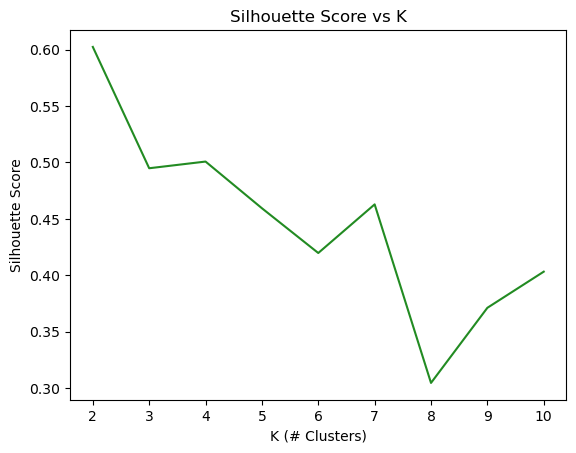

In [10]:
# create the plot

plt.plot(
    k_df['k'], 
    k_df['silhouette-score'],
    color = 'forestgreen'
)

plt.ylabel('Silhouette Score')
plt.xlabel('K (# Clusters)')
plt.title('Silhouette Score vs K')
# plt.ylim([0, 1])
plt.show()


**(VALUE: 1 POINT) Based on how the silhouette score is calculated, what is its time complexity? (e.g., O(log n))**  
You can find the definition of the silhouette score in the lecture notes, for example. 

The silhouette score is $O(n^2)$ because for each point, you have to loop through every other point to calculate the distances. 